# Practical Session on Graph Neural Networks
## student : Bazaz Samuel

**by Matthieu Nastorg and Cyriaque Rousselot**

## **PART 1 : CODING** (8/20)

### Install Pytorch Geometric

To handle graph data, we use the library Pytorch Geometric : https://pytorch-geometric.readthedocs.io/en/latest/

*   If you use _Google Colab_, simply run the following cell to install Pytorch Geometric (**advised**).
*   If you plan using your _own environment_, follow the documentation to install Pytorch Geometric : https://pytorch-geometric.readthedocs.io/en/latest/install/installation.html and skip the following cell.

In [ ]:
########## INSTALL TORCH GEOMETRIC ##################
# https://pytorch-geometric.readthedocs.io/en/latest/
#####################################################
import torch

def format_pytorch_version(version):
    return version.split("+")[0]


TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)


def format_cuda_version(version):
    return "cu" + version.replace(".", "")


CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

### Import required packages

Run the following cell to import all required packages. This cell **must not** be modified.

To significantly accelerate your training, it is advised to use GPU. Using Google Colab, you need to activate it : 

*   Edit --> Notebook Setting --> Hardware accelerator --> GPU

### Dataset

We use the Protein-Protein Interaction (PPI) network dataset which includes:
- 20 graphs for training 
- 2 graphs for validation
- 2 graphs for testing

One graph of the PPI dataset has on average 2372 nodes. Each node:
- 50 features : positional gene sets / motif gene / immunological signatures ...
- 121 (binary) labels : gene ontology sets (way to classify gene products like proteins).

**This problem aims to predict, for a given PPI graph, the correct node's labels**.

**It is a node (multi-level) classification task** (trained using supervised learning). 

For your curiosity, more details information on the dataset and some applications:
- https://cs.stanford.edu/~jure/pubs/pathways-psb18.pdf
- https://arxiv.org/abs/1707.04638

To understand how a graph data is implemented in Pytorch Geometric, refer to : https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html


On remarque que les graphes sont peu connectés mais qu'il y a une seule composante connexe.

### Define a basic Model

Here we define a very simple Graph Neural Network model which will be used as our baseline. This model consists of three graph convolutional layers (from https://arxiv.org/pdf/1609.02907.pdf). The first two layers computes 256 features, followed by an ELU activation function. The last layer is used for (multi-level) classification task, computing 121 features.

Next function is designed to evaluate the performance of the model, computing the F1-Score

### Define a better model

Now, it's your turn to improve this basic model ! To do so, complete whenever ###### YOUR ANSWER ######## and run the two following cells.

**HINT :** https://arxiv.org/pdf/1710.10903.pdf

## Answer

Ce code reprend les scripts fournis avec le TP. Ensuite le code de l'architecture introduit ici est d'abord inspiré des présentations de 
Antonio Long sur Pytorch Geometric. L'enjeux a été de comprendre les liens avec l'article de Velickovic et al, et de complexifier le modèle pour avoir 3 couches afin de s'approcher du model "Basic". Pour se faire, j'ai tiré partie du travail conséquent de Aleksa Gordić pour comprendre comment généraliser à un GAT de profondeur quelconque. La cellule ci-dessous permet d'avoir l'intégralité des visualisations, allant des données aux résultats de tests des deux models. 

C:\Users\samud\anaconda3\envs\MVA2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Number of samples in the train dataset:  20
Number of samples in the val dataset:  2
Number of samples in the test dataset:  2
Output of one sample from the train dataset:  Data(x=[1767, 50], edge_index=[2, 32318], y=[1767, 121])
Edge_index :
tensor([[   0,    0,    0,  ..., 1744, 1745, 1749],
        [ 372, 1101,  766,  ..., 1745, 1744, 1739]])
Number of features per node:  50
Number of classes per node:  121


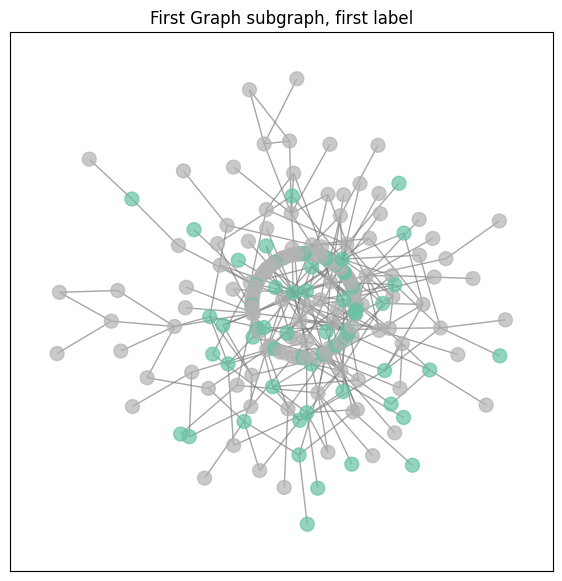


Device:  cuda
Train BasicGraphModel


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Train GAT


100%|██████████| 300/300 [09:30<00:00,  1.90s/it]
C:\Users\samud\AppData\Local\Temp\ipykernel_8528\1675392892.py:275: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  embedding_fig.show()


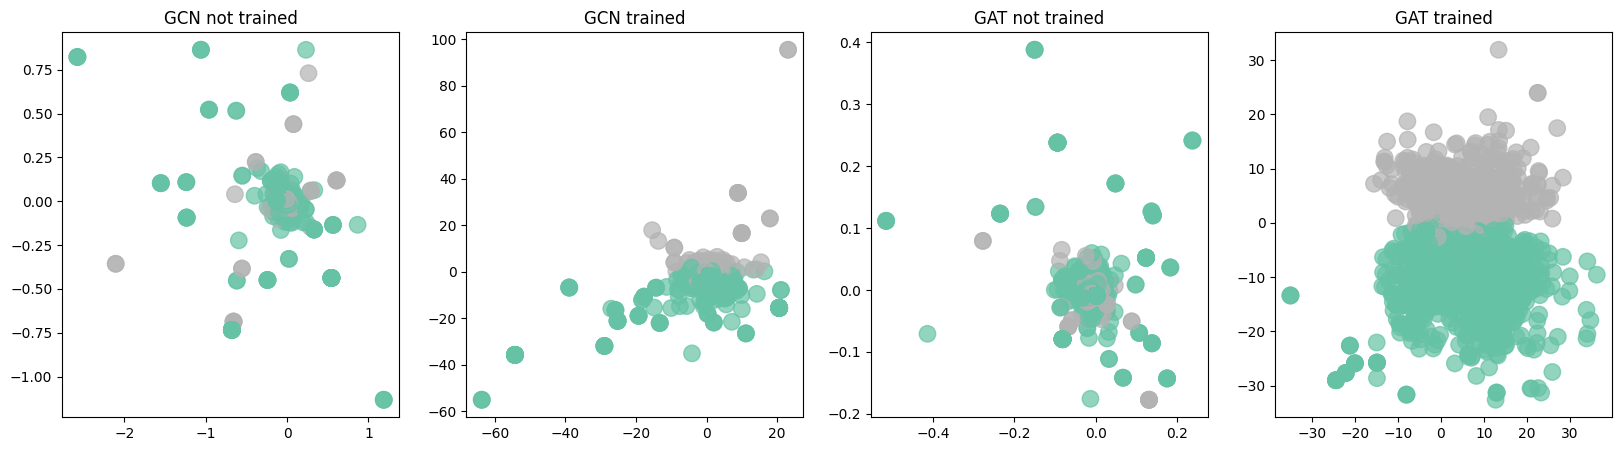

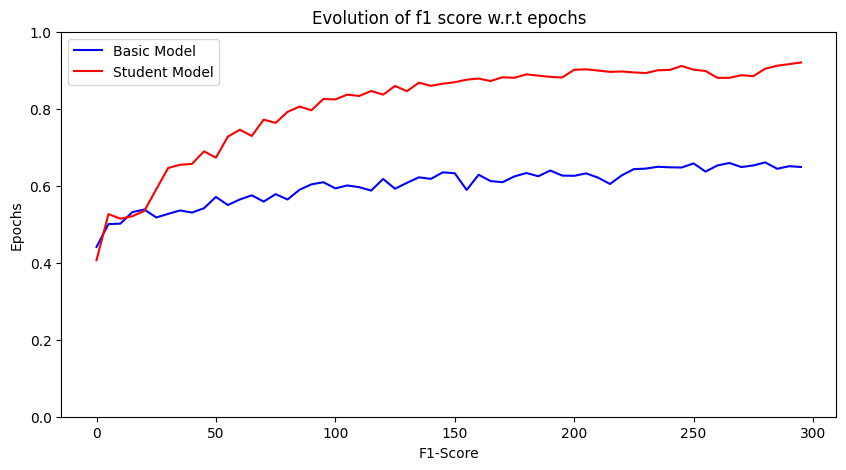

F1-Score on the test set: Basic=0.6744  Student=0.9355
Training Times (s): Basic=135.6  Student=570.3


In [1]:
############
# PACKAGES #
############
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch_geometric.nn as graphnn
from sklearn.metrics import f1_score
from torch_geometric.datasets import PPI
from torch_geometric.loader import DataLoader

import networkx as nx
import time as t
from torch_geometric.utils import to_networkx
from torch_geometric.nn import summary
from tqdm import tqdm
import torchvision
from torchview import draw_graph

##############
# Hyper para #
##############
BATCH_SIZE = 3
max_epochs = 300
hidden_size= 256

############
# Plotting #
############

def visualize_graph(G, color, kamada = True, title = "First Graph subgraph, first label"):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    if kamada:
        pos = nx.kamada_kawai_layout(G)
    else:
        pos = nx.spring_layout(G, seed=42)
    nx.draw_networkx(G, pos=pos, with_labels=False,
                     node_color=color, cmap="Set2", node_size = 100, alpha = .7, edge_color = "gray")
    plt.title(title)
    plt.show()

def embedding(model, data, ax):
    h = model(data.x, data.edge_index).detach().cpu().numpy()
    return ax.scatter(h[:, 0], h[:, 1], s=140, c=data.y[:,1], cmap="Set2", alpha = .7)

def plot_f1_score(epoch_list, scores):
    plt.figure(figsize=[10, 5])
    plt.plot(epoch_list, scores)
    plt.title("Evolution of F1S-Score w.r.t epochs")
    plt.ylim([0.0, 1.0])
    plt.show()

def plot_f1_scores(epoch_list, basic_model_scores, student_model_scores):
    plt.figure(figsize=[10, 5])
    plt.plot(epoch_list, basic_model_scores, "b", label="Basic Model")
    plt.plot(epoch_list, student_model_scores, "r", label="Student Model")
    plt.title("Evolution of f1 score w.r.t epochs")
    plt.ylim([0.0, 1.0])
    plt.ylabel("Epochs")
    plt.xlabel("F1-Score")
    plt.legend()
    plt.show()

#############################
# Data loading and plotting #
#############################

# Train Dataset
train_dataset = PPI(root="", split="train")
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
# Val Dataset
val_dataset = PPI(root="", split="val")
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
# Test Dataset
test_dataset = PPI(root="", split="test")
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Number of features and classes
n_features, n_classes = train_dataset[0].x.shape[1], train_dataset[0].y.shape[1]

print("Number of samples in the train dataset: ", len(train_dataset))
print("Number of samples in the val dataset: ", len(test_dataset))
print("Number of samples in the test dataset: ", len(test_dataset))
print("Output of one sample from the train dataset: ", train_dataset[0])
print("Edge_index :")
print(train_dataset[0].edge_index)
print("Number of features per node: ", n_features)
print("Number of classes per node: ", n_classes)

# Les données sont peu connecté bien que le graphe soit fortement connexe.
data= train_dataset[0]
sub_idx = np.arange(0,data.x.shape[0], 8)
G = to_networkx(data, to_undirected=True).subgraph(sub_idx)
visualize_graph(G, color=data.y[sub_idx,0])

#############
# Pipelines #
#############

def train(
    model, loss_fcn, device, optimizer, max_epochs, train_dataloader, val_dataloader
):
    """
    Train a PyTorch model using the specified parameters.

    Parameters:
    - model (torch.nn.Module): The PyTorch model to be trained.
    - loss_fcn (torch.nn.Module): The loss function to be used during training.
    - device (torch.device): The device on which to perform the training (e.g., 'cuda' or 'cpu').
    - optimizer (torch.optim.Optimizer): The optimizer for updating model parameters.
    - max_epochs (int): The maximum number of training epochs.
    - train_dataloader (torch.utils.data.DataLoader): DataLoader for the training dataset.
    - val_dataloader (torch.utils.data.DataLoader): DataLoader for the validation dataset.

    Returns:
    - epoch_list (list): List containing epoch numbers during training.
    - scores_list (list): List containing evaluation scores (e.g., F1-Score) on the validation set.

    During training, this function iterates over epochs, performs training steps on batches from the
    training dataloader, and evaluates the model on the validation set at specified intervals.
    """
    
    epoch_list = []
    scores_list = []

    # loop over epochs
    print(f"Train {model.__class__.__name__}")
    for epoch in tqdm(range(max_epochs)):
        model.train()
        losses = []
        # loop over batches
        for i, train_batch in enumerate(train_dataloader):
            optimizer.zero_grad() # remet les gradients à 0
            train_batch_device = train_batch.to(device)
            # logits is the output of the model
            logits = model(train_batch_device.x, train_batch_device.edge_index)
            # compute the loss
            loss = loss_fcn(logits, train_batch_device.y) # pour le model de base Binary Cross Entropy (BCE) § logit
            # optimizer step
            loss.backward() #Calcul des gradients via la valeur de la loss
            optimizer.step() #mise à jours des paramètres à partir des de l'oracle 1 de l'étape précédent et du schéma d'optimisation
            losses.append(loss.item())
        loss_data = np.array(losses).mean()
        # print("Epoch {:05d} | Loss: {:.4f}".format(epoch + 1, loss_data))

        if epoch % 5 == 0:
            # evaluate the model on the validation set
            # computes the f1-score (see next function)
            score = evaluate(model, loss_fcn, device, val_dataloader)
            # print("F1-Score: {:.4f}".format(score))
            scores_list.append(score)
            epoch_list.append(epoch)
    return epoch_list, scores_list
    
def evaluate(model, loss_fcn, device, dataloader):
    score_list_batch = []

    model.eval()
    for i, batch in enumerate(dataloader):
        batch = batch.to(device)
        output = model(batch.x, batch.edge_index)
        loss_test = loss_fcn(output, batch.y).item()
        predict = np.where(output.detach().cpu().numpy() >= 0, 1, 0)
        score = f1_score(batch.y.cpu().numpy(), predict, average="micro")
        score_list_batch.append(score)

    return np.array(score_list_batch).mean()

def get_scores(model):
    ### DEFINE LOSS FUNCTION
    """Cette classe PyTorch combine la fonction logistique (sigmoïde) 
    et la BCE Loss en une seule fonction, 
    ce qui est plus stable et efficace numériquement que de calculer ces deux parties séparément. 
    Elle prend en entrée les logits et les étiquettes (valeurs réelles, généralement 0 ou 1) et calcule la perte."""
    loss_fcn = nn.BCEWithLogitsLoss()
    
    ### DEFINE OPTIMIZER
    """
    The optimizer is called Adam because uses estimations of the first and second moments of the gradient 
    to adapt the learning rate for each weight of the neural network and uses  Adam is a combination of two gradient descent methods, 
    Momentum, and RMSP(Root Mean Square Propagation). 
    Adam is proposed as the most efficient stochastic optimization which only requires 
    first-order gradients where memory requirement is too little.
    This algorithm calculates the exponential moving average of gradients and square gradients"""
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    
    ### TRAIN THE MODEL
    epoch_list, train_scores = train(
        model,
        loss_fcn,
        device,
        optimizer,
        max_epochs,
        train_dataloader,
        val_dataloader,
    )
    score_test = evaluate(model, loss_fcn, device, test_dataloader)
    return epoch_list, train_scores, score_test

##########
# Models #
##########

class BasicGraphModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.graphconv1 = graphnn.GCNConv(input_size, hidden_size)
        self.graphconv2 = graphnn.GCNConv(hidden_size, hidden_size)
        self.graphconv3 = graphnn.GCNConv(hidden_size, output_size)
        self.elu = nn.ELU()

    def forward(self, x, edge_index):
        x = self.graphconv1(x, edge_index)
        x = self.elu(x) # c'est une activation différentiable qui tend vers -1 dans la partie négative puis correspond à x pour x>0
        x = self.graphconv2(x, edge_index)
        x = self.elu(x)
        x = self.graphconv3(x, edge_index)
        return x

class GAT(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GAT, self).__init__()
        self.gatconv1 = graphnn.GATConv(input_size, hidden_size, heads=4)
        self.gatconv2 = graphnn.GATConv(4*hidden_size, hidden_size, heads=4)
        self.gatconv3 = graphnn.GATConv(4*hidden_size, output_size, concat=False, heads=6)
        self.elu = nn.ELU()

    def forward(self, x, edge_index):            
        x = self.gatconv1(x, edge_index)
        x = self.elu(x)
        x = self.gatconv2(x, edge_index)
        x = self.elu(x)
        x = self.gatconv3(x, edge_index)
        return x

########
# Runs #
########

### DEVICE GPU OR CPU : will select GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("\nDevice: ", device)

#On initialise la figure et sa mise à jour pour les comparaisons d'embeddings
embedding_fig, ax = plt.subplots(1,4,figsize=(20,5))
def add_to_sub(i, title, model):
    embedding(model.to("cpu"), data, ax[i])
    ax[i].set_title(title)


### BASIC MODEL
basic_model = BasicGraphModel(
        input_size=n_features, hidden_size=hidden_size, output_size=n_classes
    )

add_to_sub(0,"GCN not trained", basic_model)
t_aux = t.time()
epoch_list, basic_train_scores, basic_score_test = get_scores(basic_model.to(device))
dt_basic = t.time()-t_aux
add_to_sub(1,"GCN trained", basic_model)

### STUDENT MODEL
student_model = GAT(
        input_size=n_features, hidden_size=hidden_size, output_size=n_classes
    )

add_to_sub(2,"GAT not trained", student_model)
t_aux = t.time()
epoch_list, student_train_scores, student_score_test = get_scores(student_model.to(device))
dt_student = t.time()- t_aux
add_to_sub(3,"GAT trained", student_model)


### COMPARIZON
embedding_fig.show()
plot_f1_scores(epoch_list, basic_train_scores, student_train_scores)
print("F1-Score on the test set: Basic={:.4f}  Student={:.4f}".format(basic_score_test, student_score_test))
print("Training Times (s): Basic={:.1f}  Student={:.1f}".format(dt_basic, dt_student))

## **PART 2 : QUESTIONS** (12/20)

**1. Make a small paragraph that : (4pts)**
1. Explains your achitecture and justify your choices (why the Graph Layer you chose is more efficient than the GCNLayer from the Basic Model?).
2. Analyses your results (what is the F1-Score ? are your results convincing ? what is your position w.r.t state-of-the-art ?).

L'architecture reprend la structure du GCN à trois couches et remplace les modules de convolution par des GATConv, dans l'optique de tester l'influence du passage d'une convolution spatiale à une convolution avec attention multiple toute chose égale par ailleurs. Plus précisément on utilise des unités "multihead" et on combine 4 modules de self attention pour la première et deuxième couche, et 6 pour la dernière. Le choix du nombre de "head" provient d'un travail antérieur de Aleksa Gordić, et son intérêt est de tenir compte du caractère multidimensionnel des features en apprenant plusieurs structures d'intéractions et donc plusieurs embedding potientiellement complémentaires.

L'idée ici est d'améliorer l'expressivité de notre modèle, en effet le modèle basic s'obtient en fixant l'attention égale au réseau initial. On comprend donc que le modèle ainsi créé généralise le précédent et optimise sur un espace plus grand. Il est donc logique dans le cas où la quantité de données est suffisante d'obtenir de meilleures résultats. 

C'est ce que l'on observe avec une très forte amélioration du f1 score qui passe de 0.67 à 0.93. Ce gain de performance ce fait au prix d'un coût computationnel plus grand avec une durée d'apprentissage multipliée par 4. Dans les deux cas l'embedding appris permet d'avoir des classes presque linéairement séparable (cf les plots d'embedding). On remarque cependendant que l'embedding du GCN ne s'émancipe pas trop de la structure spatiale du graphe, et la réelle force de l'attention réside dans sa capacité à diffuser les zones du graphe très concentrées et d'obtenir une représentation moins corrélée avec la répartition des noeuds.

D'après le benchmark de paperswithcode.com "node-classification-on-ppi", la performance du GAT peut être améliorée et atteindre un f1 core de 0.97, probablement avec une durée d'entrainement plus longue. Des alternatives obtiennent de meilleurs résultats allant jusqu'à un f1 de 0.99. Dans ces alternatives il y a notamment l'utilisation de "Gated Attention" (	GaAN ) qui généralise en apprennant une pondération dans l'agrégation des heads. Il y a aussi des méthodes analogues à du bootstrap qui rééchantillonnent des sous graphes pour faire de la data augmentation (ex GraphSAINT). Enfin on peut noter de très bonnes performances des méthodes de DeepCGNs, avec des dizaines à des centaines de couches. Ces derniers semblent avoir réussi à dépasser le problème de l'oversmoothing! 

**2. Provide a diagramm of your architecture, which includes a good and clear legend as well as shapes information. The diagramm must be submitted as an external file, along with this notebook (PDF, JEPG or PNG format accepted). (2pts)**

Vous trouverez ci-dessous des visualisations moins détaillés de l'architecture introduite. Pour plusde détaille , voir "GAT3_detaille".

In [41]:
pip install graphviz
pip install torchview

Note: you may need to restart the kernel to use updated packages.



(process:7400): Pango-WARNING **: 11:07:53.422: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


+---------------------+---------------------------+----------------+-----------+
| Layer               | Input Shape               | Output Shape   | #Param    |
|---------------------+---------------------------+----------------+-----------|
| GAT                 | [5524, 50], [2, 161976]   | [5524, 121]    | 1,850,917 |
| ├─(gatconv1)GATConv | [5524, 50], [2, 161976]   | [5524, 1024]   | 54,272    |
| ├─(gatconv2)GATConv | [5524, 1024], [2, 161976] | [5524, 1024]   | 1,051,648 |
| ├─(gatconv3)GATConv | [5524, 1024], [2, 161976] | [5524, 121]    | 744,997   |
| ├─(elu)ELU          | [5524, 1024]              | [5524, 1024]   | --        |
+---------------------+---------------------------+----------------+-----------+


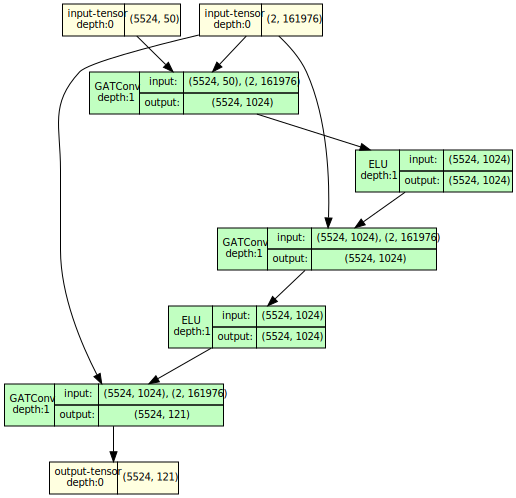

In [11]:
print(summary(student_model.to("cpu"), test_dataset.x, test_dataset.edge_index))
model_graph = draw_graph(student_model,
                         input_data = (test_dataset.x, test_dataset.edge_index), 
                         graph_name='GAT3',
                         expand_nested=True, 
                         save_graph  = False, 
                         roll=False, 
                         depth = 1, #1 or 2
                         hide_inner_tensors=True,
    hide_module_functions=True)
model_graph.visual_graph

**3. Make a small paragraph that explains: (6pts)**
1. What _oversmoothing_ is in the context of Graph Neural Network. Why is it an issue ? 
2. Are there solutions to overcome it ? 
3. Do you think the model you constructed is robust with respect to oversmoothing ? Why ?

L'oversmoothing provient du noyau de convolution utilisé pour les graphes qui n'utilise que des poids positifs. A la manière d'un flou gaussien, il en résulte une diffusion et une moyenisation de l'information délétère pour discriminer les noeuds: nos embeddings finissent par converger vers un même état moyen. On comprend ainsi pourquoi la smoothness de l'embedding diminue avec le nombre de convolution, ce qui conduit à un signal sur graphe homogène et donc inutilisable pour de la classification.

Une solution très simple pour éviter cela est de se limiter dans la profondeur du réseau, et cela explique pourquoi les DeepCGNs ne sont pas hégémoniques, et qu'on l'on trouve beaucoup de modèles peu profonds dans ce domaine. Notre architecture à 3 couches est ainsi raisonnablement touchée par l'oversmoothing car notre signal n'est pas trop "floutté". D'ailleurs trois couches semblent être le meilleur compromis au vu des différents tests que j'ai pu réalisé. Contrairement à la croyance populaire, le mécanisme d'attention ne permet pas de prévenir l'oversmoothing ( voir https://arxiv.org/pdf/2305.16102.pdf), ce qui est logique quand on sait que cela consite à faire des combinaisons convexes en raison du softmax et donc des barycentres.

Pour augmenter le nombre de couches, l'idée est de garder du "contraste". Une approche naive serait d'autoriser des poids négatifs dans des couches cependant ça ne semble pas être une bonne piste, vu que je n'ai rien vu de tel dans la litérature pour l'instant. Une astuce d'avantage utilisée et qui est au coeur des architectures qui performent actuellement, est de s'inspirer de ResNets et d'introduire des "skip connection" ou connexion résiduels, qui permettent de transférer de l'information d'une couche à une autre sans convolutions et ainsi de tirer profit du "contraste" des couches précédentes. On peut aussi normaliser les couches à chaque étape de manière à conserver une variance stable, mais ça risque de ne pas empêcher une sorte d'isotropie dans notre embedding et une disparition totale de la topologie de nos features. Une solution plus sophistiquée est alors d'utiliser l'information des structures locales (par un knn par exemple) pour adapter la pondération, de manière à conserver certaines propriétés topologiques de notre signal sur graphe. Enfin, des heuristiques simple comme les "edge drop" permettent de retarder l'oversmoothing, mais dans notre cas ça diminuait beaucoup les performances.

Ainsi, la prochaine étape pourrait être d'ajouter des "skip connection" et des "denses layer" pour augmenter la profondeur de notre réseau et ainsi espérer passer à un f1 de 0.99!